# Assignment 6

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, mean_squared_error, r2_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestRegressor

In [39]:
energy_df = pd.read_csv('energy_dataset_.csv')

print(energy_df.shape)

(15000, 13)


In [40]:
energy_df.isnull().sum()

Type_of_Renewable_Energy         0
Installed_Capacity_MW            0
Energy_Production_MWh            0
Energy_Consumption_MWh           0
Energy_Storage_Capacity_MWh      0
Storage_Efficiency_Percentage    0
Grid_Integration_Level           0
Initial_Investment_USD           0
Funding_Sources                  0
Financial_Incentives_USD         0
GHG_Emission_Reduction_tCO2e     0
Air_Pollution_Reduction_Index    0
Jobs_Created                     0
dtype: int64

#  Data Encoding: One-hot encoding for categorical variables

In [41]:
categorical_columns = ['Type_of_Renewable_Energy', 'Grid_Integration_Level', 'Funding_Sources']
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(energy_df[categorical_columns])
encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

In [42]:
energy_df_encoded = energy_df.drop(categorical_columns, axis=1).join(encoded_df)

# # Data Normalization and Scaling


In [43]:
numerical_columns = energy_df_encoded.columns.difference(encoded_feature_names)
scaler = StandardScaler()
energy_df_encoded[numerical_columns] = scaler.fit_transform(energy_df_encoded[numerical_columns])

# # Check for outliers using box plots

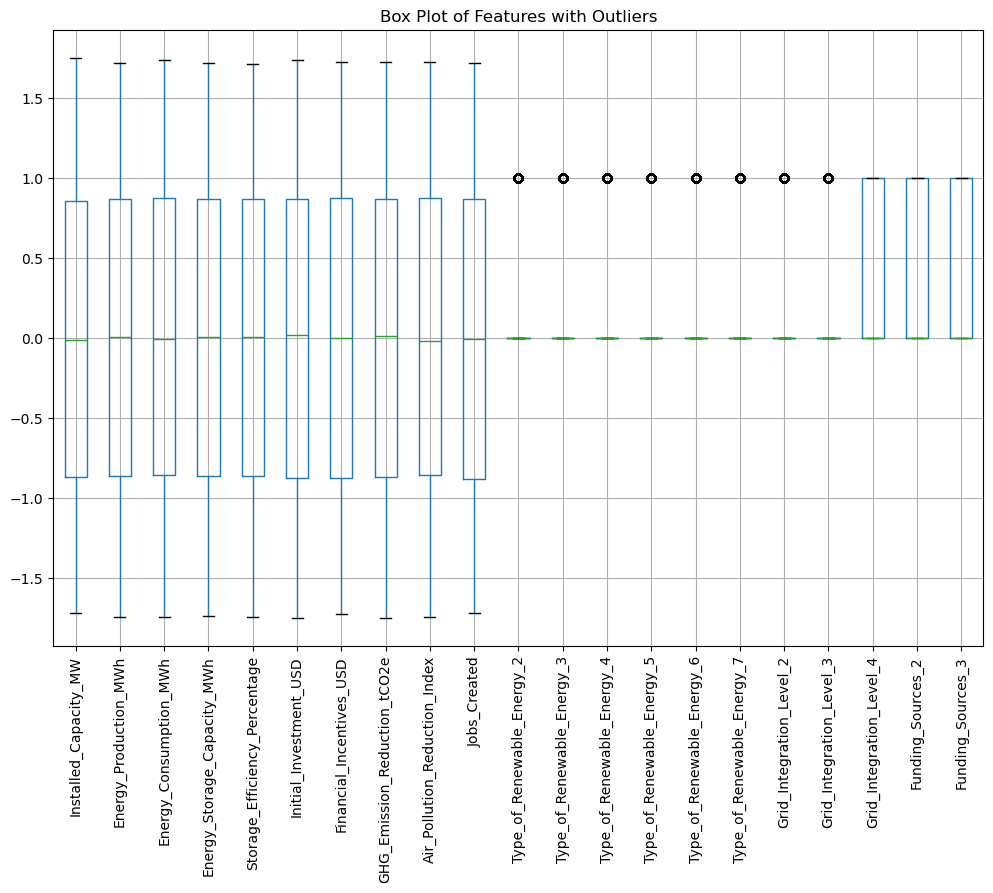

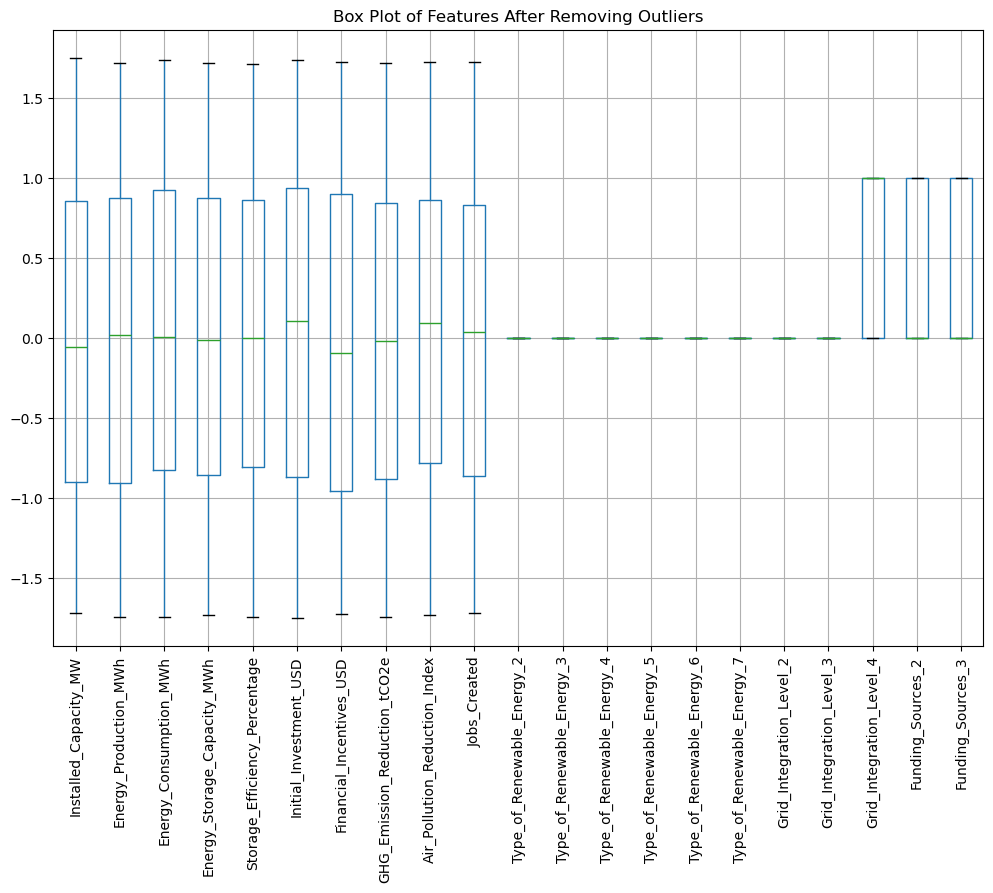

In [44]:
plt.figure(figsize=(12, 8))
energy_df_encoded.boxplot()
plt.title('Box Plot of Features with Outliers')
plt.xticks(rotation=90)
plt.show()

# Removing outliers
Q1 = energy_df_encoded.quantile(0.25)
Q3 = energy_df_encoded.quantile(0.75)
IQR = Q3 - Q1
energy_df_encoded = energy_df_encoded[~((energy_df_encoded < (Q1 - 1.5 * IQR)) | (energy_df_encoded > (Q3 + 1.5 * IQR))).any(axis=1)]

# Check the box plot again after removing outliers
plt.figure(figsize=(12, 8))
energy_df_encoded.boxplot()
plt.title('Box Plot of Features After Removing Outliers')
plt.xticks(rotation=90)
plt.show()

# Splitting the values

C:\Users\91914\an\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


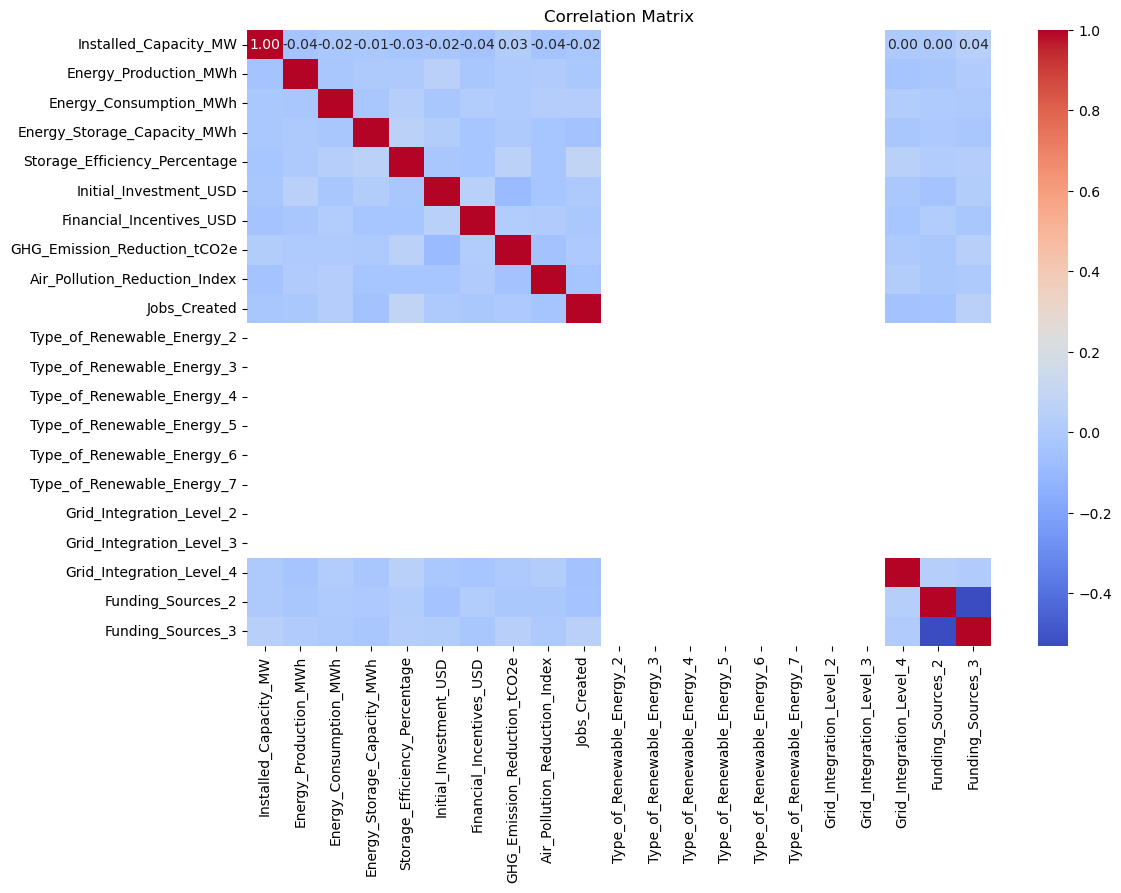

No features selected with the given correlation threshold.


In [46]:
if len(energy_df_encoded) > 1:
    X = energy_df_encoded.drop('Energy_Production_MWh', axis=1)
    y = energy_df_encoded['Energy_Production_MWh']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    correlation_matrix = energy_df_encoded.corr()
    correlation_with_target = correlation_matrix["Energy_Production_MWh"].abs().sort_values(ascending=False)
    selected_features = correlation_with_target[correlation_with_target > 0.1].index
    selected_features = selected_features.drop('Energy_Production_MWh', errors='ignore')

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()

    if not selected_features.empty:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=correlation_with_target[selected_features].values, y=selected_features)
        plt.title('Selected Features and Their Correlation with Energy Production (MWh)')
        plt.xlabel('Correlation Coefficient')
        plt.ylabel('Features')
        plt.show()
    else:
        print("No features selected with the given correlation threshold.")


# Training the example with exampel random forest

In [47]:
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Convert regression problem to classification for confusion matrix
    # Assuming a threshold for classification (e.g., median of y_train)
    threshold = np.median(y_train)
    y_train_class = (y_train >= threshold).astype(int)
    y_test_class = (y_test >= threshold).astype(int)
    y_pred_class = (y_pred >= threshold).astype(int)

## Confusion matrix 

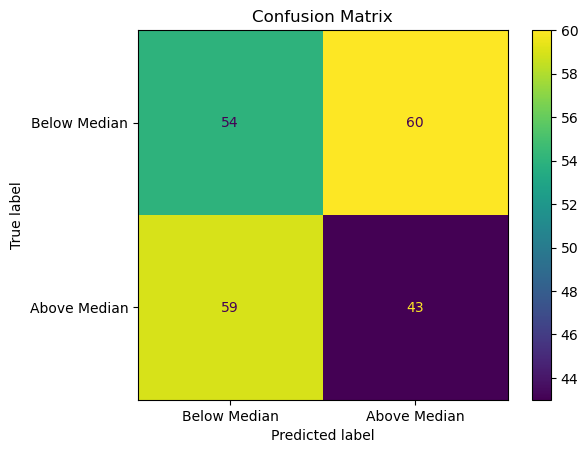

In [48]:
    cm = confusion_matrix(y_test_class, y_pred_class)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Below Median', 'Above Median'])
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

## other evaluation matrices

In [49]:
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared:", r2)

Mean Squared Error (MSE): 1.1330733728787876
Root Mean Squared Error (RMSE): 1.0644591926789808
R-squared: -0.10257877995047804


#     # Hyperparameter Tuning: Grid Search and Random Search

In [54]:
if len(energy_df_encoded) > 1:
    X = energy_df_encoded.drop('Energy_Production_MWh', axis=1)
    y = energy_df_encoded['Energy_Production_MWh']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    correlation_matrix = energy_df_encoded.corr()
    correlation_with_target = correlation_matrix["Energy_Production_MWh"].abs().sort_values(ascending=False)
    selected_features = correlation_with_target[correlation_with_target > 0.1].index
    selected_features = selected_features.drop('Energy_Production_MWh', errors='ignore')

    

    if not selected_features.empty:
        
        plt.ylabel('Features')
        
    else:
        print("No features selected with the given correlation threshold.")

    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    print("Best parameters found by Grid Search:", grid_search.best_params_)

    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, cv=3, random_state=42, n_jobs=-1, verbose=2)
    random_search.fit(X_train, y_train)
    print("Best parameters found by Random Search:", random_search.best_params_)
else:
    print("Not enough data available after removing outliers.")


No features selected with the given correlation threshold.
Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best parameters found by Grid Search: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found by Random Search: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
